<a href="https://colab.research.google.com/github/julrods/cyber-bullying-detector/blob/main/Copia_de_20_1_1_Text_Classification_mydata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Article" data-toc-modified-id="Article-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Article</a></span></li><li><span><a href="#Colab-notebook" data-toc-modified-id="Colab-notebook-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Colab notebook</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="#Load-libraries" data-toc-modified-id="Load-libraries-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Setup-BERT" data-toc-modified-id="Setup-BERT-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Setup BERT</a></span></li><li><span><a href="#Build-model" data-toc-modified-id="Build-model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Compile-model" data-toc-modified-id="Compile-model-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Compile model</a></span></li><li><span><a href="#Train-model-(skip-this)" data-toc-modified-id="Train-model-(skip-this)-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Train model (skip this)</a></span></li><li><span><a href="#Load-saved-model" data-toc-modified-id="Load-saved-model-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Load saved model</a></span></li><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Evaluate model</a></span></li><li><span><a href="#Apply-to-new-data" data-toc-modified-id="Apply-to-new-data-3.9"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>Apply to new data</a></span></li></ul></li></ul></div>

## Article 

- https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a

The objective of this model is to sort bank complaints to send them to the person who is resposible for that type of issues for each product. 

Este es un ejemplo con BERT, pero si buscamos artículos hay muchos otros modelos preentrenados como GPT-J, GPT-NEO, etc

## Colab notebook
- https://colab.research.google.com/drive/1TagJl22dqz7ycacoU2WDGF5l3w5L3dSi#scrollTo=TrHQu627nu7i

## Code

### Load libraries

- transformers:
  - TFBertModel: the model itself
  - BertConfig: the configuration
  - BertTokenizerFast: a tokenizer to divide in sentences and words in a different way from spacy. 

In [1]:
pip install transformers

     |████████████████████████████████| 2.6 MB 6.8 MB/s 
     |████████████████████████████████| 3.3 MB 54.6 MB/s 
     |████████████████████████████████| 636 kB 64.2 MB/s 
     |████████████████████████████████| 895 kB 51.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
#######################################
### -------- Load libraries ------- ### 

#Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import to_categorical, plot_model

# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Load data

In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1W2uM-pWHd9TX0G9WjXKkAORDyqVoDbyu'
downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [4]:
### Import data from csv
downloaded.GetContentFile('aggression_parsed_dataset.csv')  
data_original = pd.read_csv('aggression_parsed_dataset.csv')
data = data_original.copy()

In [5]:
data.head()

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,0.900000,0.100000,0
1,1,` :: the term ``standard model`` is itself le...,1.000000,0.000000,0
2,2,"True or false, the situation as of March 200...",1.000000,0.000000,0
3,3,"Next, maybe you could work on being less cond...",0.555556,0.444444,0
4,4,This page will need disambiguation.,1.000000,0.000000,0


In [6]:
# Select required columns
data = data[['Text', 'oh_label']]

# Remove a row if any of the three remaining columns are missing
data = data.dropna()

data, data_test = train_test_split(data, test_size = 0.2, stratify = data[['oh_label']])

In [7]:
data.head()

,Text,oh_label
52113,==Don't lecture me== Keep your hypocritical ...,1
55405,Labeling Alex Jones as a paleoConservative is...,1
84319,::Am waiting for your explanation. Did you n...,0
78704,How does it feel to be a stupid bitch who edi...,1
90465,== question == About your undo here. Can i ...,0


### Setup BERT

Dentro de BERT hay diferentes modelos. 'bert-base-uncased' es el básico, sin mayúsculas, así que tendremos que trabajar en minúsculas. 

Una limitación que tienen los transformers es que hay que fijar la longitud de la secuencia (número de palabras máximas). Suele ser 100. Por eso el input a los modelos está limitado, no podemos pasar un texto largo, solo unas pocas frases. 

**Aquí nos saltamos el trabajo de entrenamiento** porque tenemos el modelo ya entrenado, solo tenemos que cargarlo y hacer predicciones. 

Tenemos que crear un tokenizador, que dividrá el texto en secuencias de 100, pone carácteres de control, etc. También creamos el modelo a partir del modleo entrenado. 

In [8]:
#######################################
### --------- Setup BERT ---------- #### Name of the BERT model to use


model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 100 

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Build model

In [9]:
#######################################
### ------- Build the model ------- #### TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0] 

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
oh_label = Dense(1, activation='sigmoid', name='oh_label')(pooled_output)
outputs = {'oh_label': oh_label}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_Binary_Classifier')

# Take a look at the model
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "BERT_Binary_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
oh_label (Dense)             (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


El dropout es una especie de reducción de dimensionalidad en la que quitamos capas de neuronas para evitar el overfitting. 

Issue y product son redes neuronales densas.

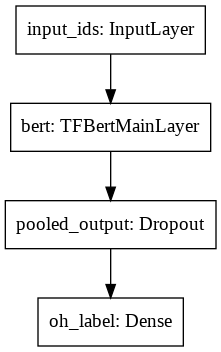

In [10]:
plot_model(model)

### Compile model

In [11]:
#######################################
### ------- Train the model ------- ###

# Set an optimizer: definimos el algoritmo de gradien descent
optimizer = Adam()

#optimizer = Adam(
#    learning_rate=5e-05,
#    epsilon=1e-08,
#    decay=0.01,
#    clipnorm=1.0)# Set loss and metrics

# definimos la métrica de error que vamos a minimizar
loss = {'oh_label': BinaryCrossentropy(from_logits = False)}

# Deifinimos la métrica de accuracy
metric = {'oh_label': BinaryAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
y = to_categorical(data['oh_label'])

# Tokenize the input (takes some time)

x = tokenizer(
    text=data['Text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Fit the model

### Train model (skip this)

Los modelos tienen la función save_weights que sirve para guardar los coeficientes: model.save_weights. Así solo tendremos que entrenar el modelo una vez en una máquina potente y luego cargar los pesos cuando los queramos reutilizar. 

In [12]:
# testing that the colab GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
# Esta es la parte que tarda más. En un ordenador normal puede tardar 30h, si lo hacemos con colab que se pueden utilizar GPUs, tarda 30 min
# Sacar primero la estimación del tiempo
#history = model.fit(
#    x={'input_ids': x['input_ids']},
#    y={'oh_label': y[:,0]},
#    validation_split=0.2,
#    batch_size=64,
#    epochs=2)

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
#model.save('/content/gdrive/MyDrive/Cyber-bullying-project/iteration_1_model_weights.h5')

### Load saved model 

In [16]:
model.load_weights('/content/gdrive/MyDrive/Cyber-bullying-project/iteration_1_model_weights.h5')

### Evaluate model

Pasamos a evaluar el modelo. Creamos datasets de test y los convertimos con el tokenizer y llamamos a la función evaluate. 

In [17]:
#######################################
### ----- Evaluate the model ------ #### Ready test data
test_y = to_categorical(data_test['oh_label'])
test_x = tokenizer(
    text=data_test['Text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)# Run evaluation


In [18]:
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'oh_label': test_y[:,0]}
)

725/725 [==============================] - 148s 201ms/step - loss: 0.3966 - accuracy: 0.8724


### Apply to new data

Nos da la predicción en términos de probabilidades, tendremos que buscar cuál es el coeficiente máximo de las dos salidas que da, es decir, cual es el issue y el producto con el valor más alto. Con np.argmax buscamos cuál es el label de issue que tiene el valor más alto, y lo mismo con el label de producto. Si buscamos el elemento original con iloc vemos que ha acertado. 

In [19]:
data_test.iloc[0]

Text        `514896247&oldid;=514849350]  ... :*My use of ...
oh_label                                                    0
Name: 94137, dtype: object

In [20]:
pred = model.predict(test_x['input_ids'][0:1])
pred

{'oh_label': array([[0.80786157]], dtype=float32)}

In [21]:
data_test.iloc[1]

Text        Well for a start, giving articles accurate tit...
oh_label                                                    0
Name: 93103, dtype: object

In [22]:
pred2 = model.predict(test_x['input_ids'][1:2])
pred2

{'oh_label': array([[0.80786145]], dtype=float32)}

In [23]:
pred3 = model.predict(test_x['input_ids'])
pred3

{'oh_label': array([[0.80786145],
        [0.80786157],
        [0.80786145],
        ...,
        [0.80786157],
        [0.80786157],
        [0.80786157]], dtype=float32)}

In [38]:
max = pred3['oh_label'].max()
min = pred3['oh_label'].min()

print(f'max: {max}')
print(f'min: {min}')

max: 0.8078615665435791
min: 0.8078613877296448
